An algorithm for creating images and creating textures is called picture quilting with min cut. In order to generate a bigger synthesized image with the fewest obvious seams or imperfections, it entails sewing together patches of a particular input texture.

Finding patches that can seamlessly overlap with the current picture while reducing the disparity between the overlapping regions is the main notion underlying image quilting with min cut. This is accomplished by taking into account a cost function that calculates the variance between patches and the base picture. The algorithm looks for the best changes to reduce this cost.

The min cut technique is then used to minimize visible seams and smooth the transition between patches. Finding a route across the overlapping regions with the lowest overall cost is required. The pixels on this route, which symbolizes the cut, are altered to provide a seamless transition.

In [ ]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from skimage import util

During the image quilting process, the following function determines the difference between a patch and the overlapping areas of an existing picture (img) at a certain point (y, x).


In [ ]:
def compute_patch_difference(patch, patch_size, overlap_size, img, y, x):
    difference = 0

    # upper patch
    if y > 0:
        up = patch[:overlap_size, :] - img[y:y+overlap_size, x:x+patch_size]
        difference += np.sum(up**2)

    # left patch
    if x > 0:
        left = patch[:, :overlap_size] - img[y:y+patch_size, x:x+overlap_size]
        difference += np.sum(left**2)

    # intersection
    if x > 0 and y > 0:
        corner = patch[:overlap_size, :overlap_size] - img[y:y+overlap_size, x:x+overlap_size]
        difference -= np.sum(corner**2)

    return difference

the following function is used to find the patch in the base_img that has the minimum difference when compared to the img at a specific position (y, x) during the image quilting process.

In [ ]:
def find_optimal_patch(base_img, patch_size, overlap_size, img, y, x):
    h, w, _ = base_img.shape
    differences = np.zeros((h - patch_size, w - patch_size))

    for i in range(h - patch_size):
        for j in range(w - patch_size):
            patch = base_img[i:i+patch_size, j:j+patch_size]
            differences[i, j]  = compute_patch_difference(patch, patch_size, overlap_size, img, y, x)

    i, j = np.unravel_index(np.argmin(differences), differences.shape)
    return base_img[i:i+patch_size, j:j+patch_size]

Following code is used to find the minimal cut path in a matrix represented by difference_matrix. It initializes a priority queue which each element in this queue is a tuple containing the difference value and a list representing the path taken so far. The initial elements of the priority queue are formed by enumerating the values in the first row of difference_matrix and creating tuples of (difference, [i]). then The priority queue `pq` is heapified, which rearranges its elements so that the element with the smallest difference value is at the top.
It performs breadth-first search on the difference_matrix and finds the minimal cut path by considering the neighbors of each position and accumulating the differences along the path. It returns the path that reaches the bottom of the matrix with the smallest accumulated difference.

In [ ]:
def find_minimal_cut_path(difference_matrix):
    pq = [(difference, [i]) for i, difference in enumerate(difference_matrix[0])]
    heapq.heapify(pq)

    h, w = difference_matrix.shape
    visited = set()

    while pq:
        difference, path = heapq.heappop(pq)
        depth = len(path)
        current_index = path[-1]

        if depth == h:
            return path

        for neighbour in range(-1, 2):
            next_index = current_index + neighbour

            if 0 <= next_index < w:
                if (depth, next_index) not in visited:
                    cumulative_difference = difference + difference_matrix[depth, next_index]
                    heapq.heappush(pq, (cumulative_difference, path + [next_index]))
                    visited.add((depth, next_index))

The apply_minimal_cut function blends a patch onto an image by minimizing visible seams. It compares the overlapping regions between the patch and the image, calculates the squared differences, and finds the minimal cut path that represents the seam with the least differences. It creates a boolean mask indicating which pixels should be replaced with pixels from the image. By copying pixels from the image to the patch based on the mask, it seamlessly blends the patch into the image, reducing visible seams and improving the overall appearance of the composition.

In [ ]:
def apply_minimal_cut(patch, patch_size, overlap_size, img, y, x):
    h, w, _ = patch.shape
    patch_copy = patch.copy()
    minimal_cut = np.zeros_like(patch_copy, dtype=bool)

    if y > 0:
        up_patch = patch_copy[:overlap_size, :, :]
        up_region = img[y:y+overlap_size, x:x+w, :]
        up_mask = np.sum((up_patch - up_region) ** 2, axis=2)
        up_seam = find_minimal_cut_path(up_mask.T)

        for j in range(w):
            minimal_cut[:up_seam[j], j, :] = True

    if x > 0:
        left_patch = patch_copy[:, :overlap_size, :]
        left_region = img[y:y+h, x:x+overlap_size, :]
        left_mask = np.sum((left_patch - left_region) ** 2, axis=2)
        left_seam = find_minimal_cut_path(left_mask)

        for i in range(h):
            minimal_cut[i, :left_seam[i], :] = True

    np.copyto(patch_copy, img[y:y+h, x:x+w, :], where=minimal_cut)

    return patch_copy


 First function initializes the dimensions of the quilt based on the patch size and number of patches. Then, it iterates over the number of patches in rows and columns. For each patch, it determines the coordinates (y, x) where the patch should be placed in the quilt. If it's the first patch (i.e., top-left corner), a random patch is generated using the random_patch function. Otherwise, it finds the optimal patch by calling the find_optimal_patch function and applies minimal cut using apply_minimal_cut function to smooth the patch edges. Finally, the patch is assigned to the corresponding region in the quilt. The resulting quilt is converted to an image using Image.fromarray and returned.

 Second function generates random coordinates within the image bounds and returns the patch of the specified size starting from those coordinates. This is used to initialize the top-left corner patch in the quilt with a random patch.

In [ ]:
import random

def create_quilt(input_image, patch_size, num_patches):
    overlap_size = patch_size // 6
    num_patches_H, num_patches_W = num_patches

    quilt_height = (num_patches_H * patch_size) - (num_patches_H - 1) * overlap_size
    quilt_width = (num_patches_W * patch_size) - (num_patches_W - 1) * overlap_size

    quilt = np.zeros((quilt_height, quilt_width, input_image.shape[2]))

    for i in range(num_patches_H):
        for j in range(num_patches_W):
            y = i * (patch_size - overlap_size)
            x = j * (patch_size - overlap_size)

            if i == 0 and j == 0:
                patch = random_patch(input_image, patch_size)
            else:
                patch = find_optimal_patch(input_image, patch_size, overlap_size, quilt, y, x)
                patch = apply_minimal_cut(patch, patch_size, overlap_size, quilt, y, x)

            quilt[y:y+patch_size, x:x+patch_size] = patch

    quilt_image = Image.fromarray((quilt * 255).astype(np.uint8))
    return quilt_image

def random_patch(input_image, patch_size):
    h, w, _ = input_image.shape
    rand_h = random.randint(0, h - patch_size)
    rand_w = random.randint(0, w - patch_size)
    return input_image[rand_h:rand_h+patch_size, rand_w:rand_w+patch_size]

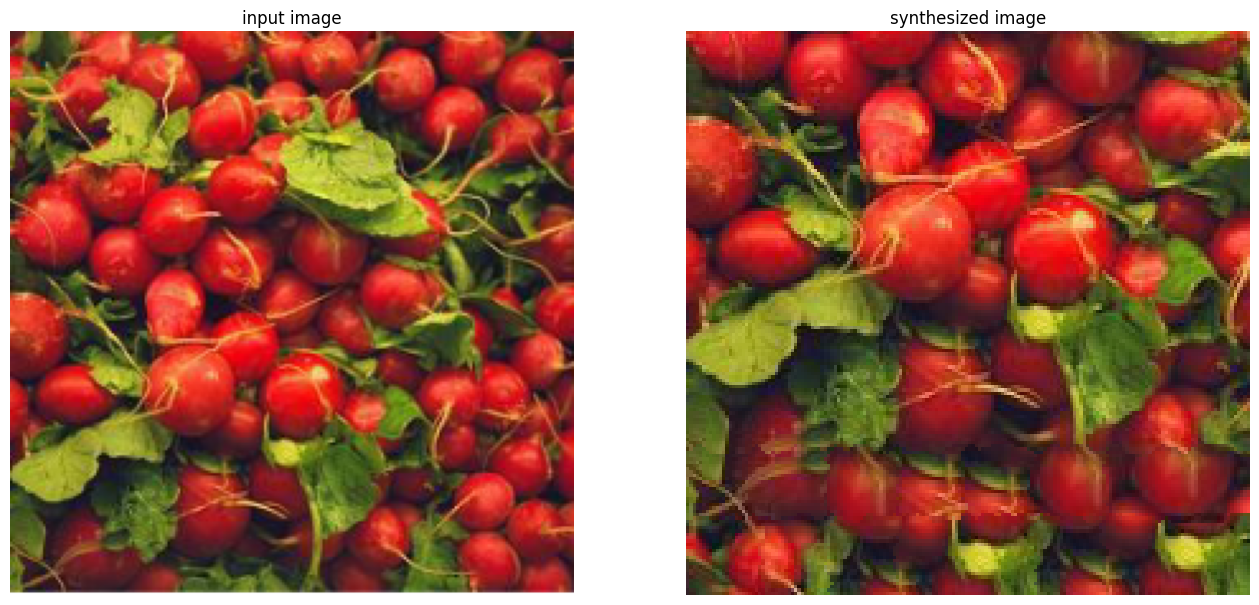

In [ ]:
input_image = cv2.imread('1.png')
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
input_image = util.img_as_float(input_image)

patch_size = 25
num_patches = (8, 8)
quilt_image = create_quilt(input_image, patch_size, num_patches)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.axis('off')
plt.title("input image")

plt.subplot(1, 2, 2)
plt.imshow(quilt_image)
plt.axis('off')
plt.title("synthesized image")

plt.show()

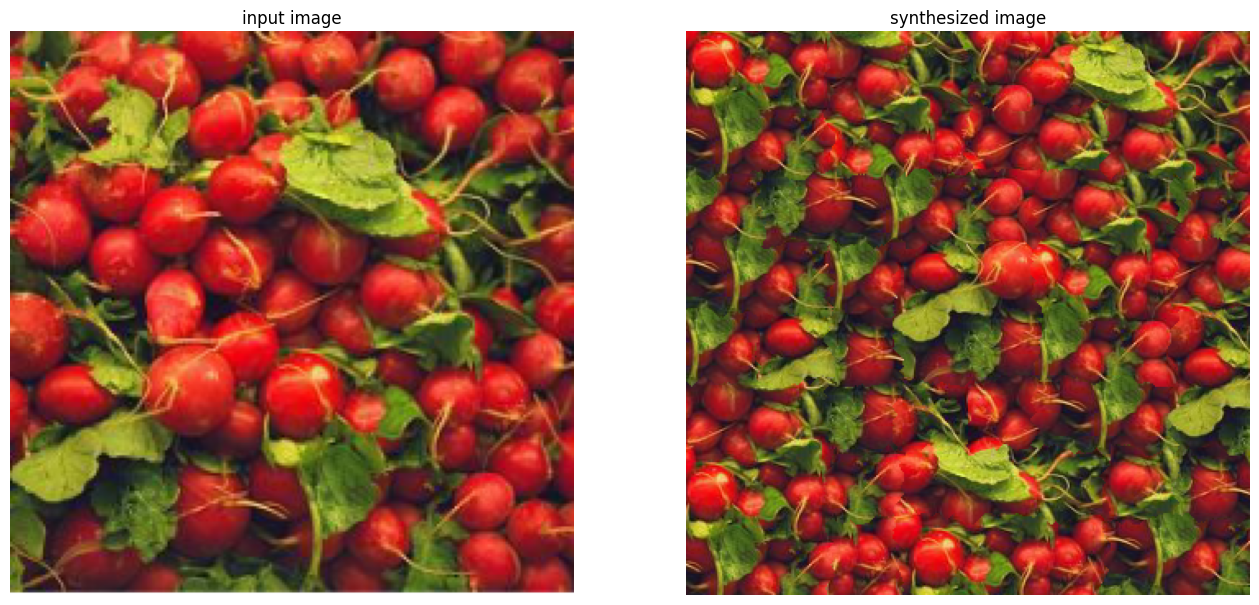

In [ ]:
input_image = cv2.imread('1.png')
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
input_image = util.img_as_float(input_image)

patch_size = 50
num_patches = (8, 8)
quilt_image = create_quilt(input_image, patch_size, num_patches)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.axis('off')
plt.title("input image")

plt.subplot(1, 2, 2)
plt.imshow(quilt_image)
plt.axis('off')
plt.title("synthesized image")

plt.show()

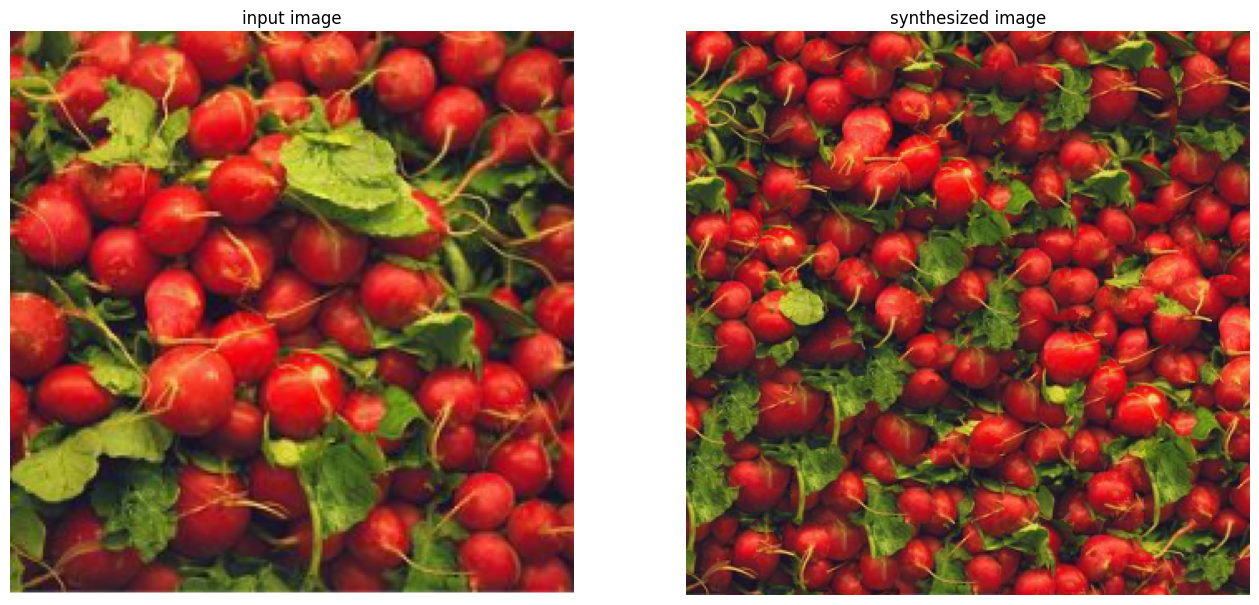

In [ ]:
input_image = cv2.imread('1.png')
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
input_image = util.img_as_float(input_image)

patch_size = 25
num_patches = (16, 16)
quilt_image = create_quilt(input_image, patch_size, num_patches)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.axis('off')
plt.title("input image")

plt.subplot(1, 2, 2)
plt.imshow(quilt_image)
plt.axis('off')
plt.title("synthesized image")

plt.show()

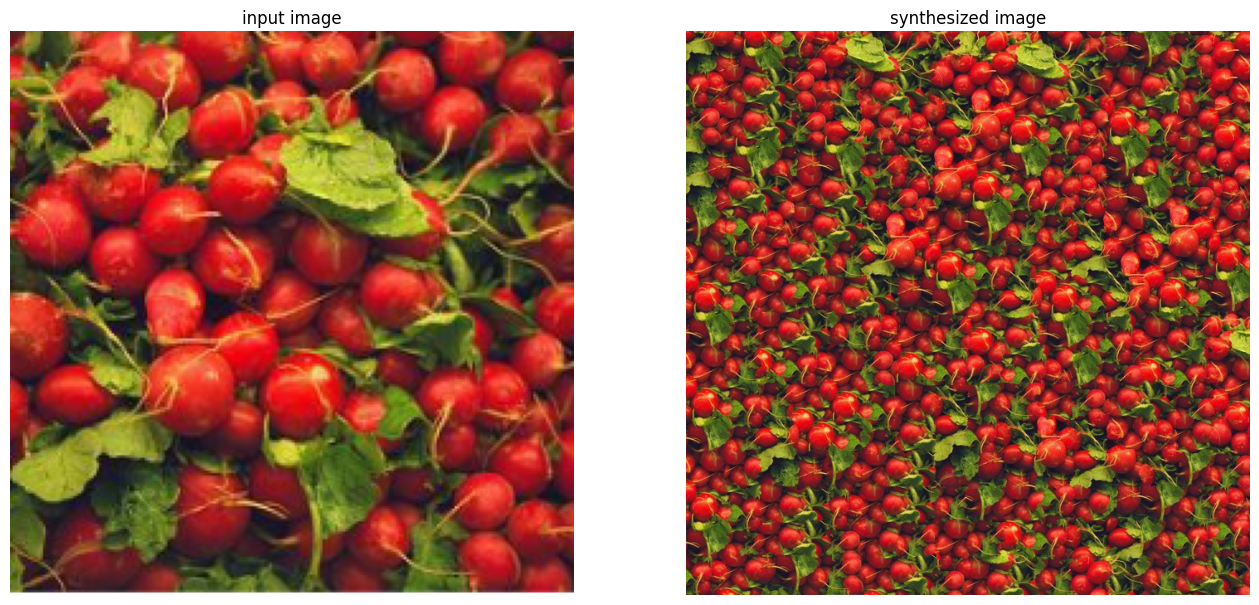

In [ ]:
input_image = cv2.imread('1.png')
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
input_image = util.img_as_float(input_image)

patch_size = 50
num_patches = (16, 16)
quilt_image = create_quilt(input_image, patch_size, num_patches)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.axis('off')
plt.title("input image")

plt.subplot(1, 2, 2)
plt.imshow(quilt_image)
plt.axis('off')
plt.title("synthesized image")

plt.show()

As it can be seen from above experiments, result may differ by increasing patch_size and num_patches parameters.

A larger patch size means that each patch used in the synthesis process will cover a larger area of the input image. As a result, the synthesized image will have larger coherent regions and less fine-grained details. The overall structure and patterns in the input image will be more pronounced in the synthesized image.

Increasing the number of patches used to create the quilted image will lead to a higher density of patches in the final synthesized image. This means that more patches will be selected and placed in the quilt, resulting in a more accurate representation of the input image. The synthesized image will have more intricate patterns and finer details as a result.

By increasing both patch_size and num_patches, you can create a quilted image that captures larger-scale patterns and finer details from the input image. However, it's important to note that increasing these parameters may also require more computational resources and time to generate the synthesized image.

other images results are presented in the following cells:

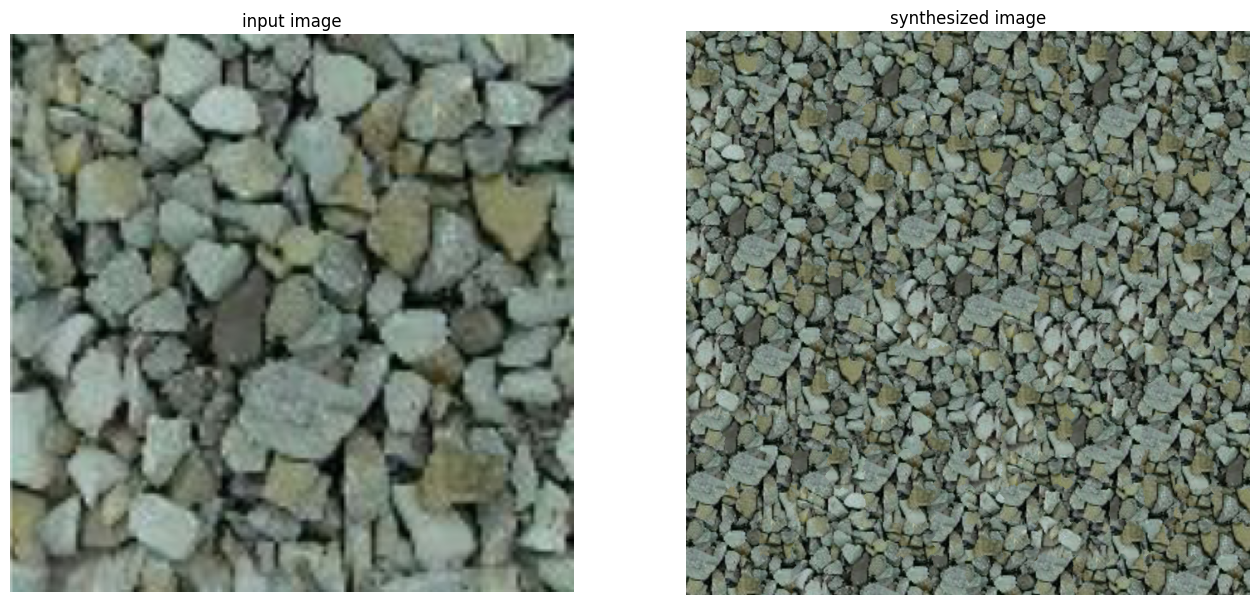

In [ ]:
input_image = cv2.imread('2.png')
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
input_image = util.img_as_float(input_image)

patch_size = 50
num_patches = (16, 16)
quilt_image = create_quilt(input_image, patch_size, num_patches)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.axis('off')
plt.title("input image")

plt.subplot(1, 2, 2)
plt.imshow(quilt_image)
plt.axis('off')
plt.title("synthesized image")

plt.show()

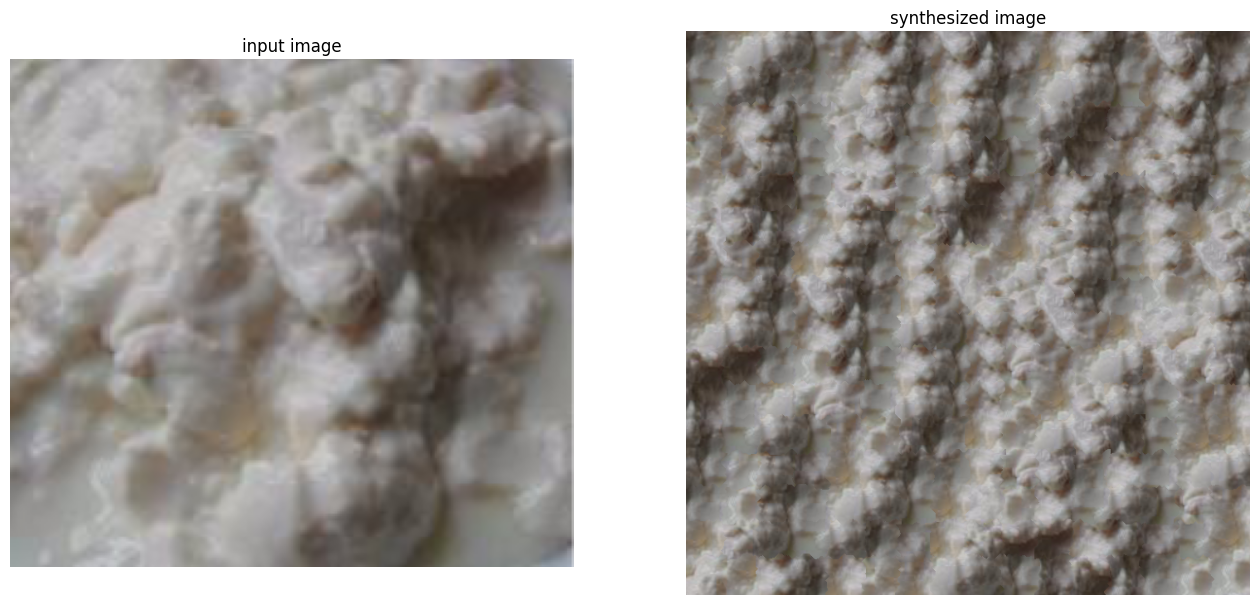

In [ ]:
input_image = cv2.imread('3.png')
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
input_image = util.img_as_float(input_image)

patch_size = 50
num_patches = (16, 16)
quilt_image = create_quilt(input_image, patch_size, num_patches)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.axis('off')
plt.title("input image")

plt.subplot(1, 2, 2)
plt.imshow(quilt_image)
plt.axis('off')
plt.title("synthesized image")

plt.show()

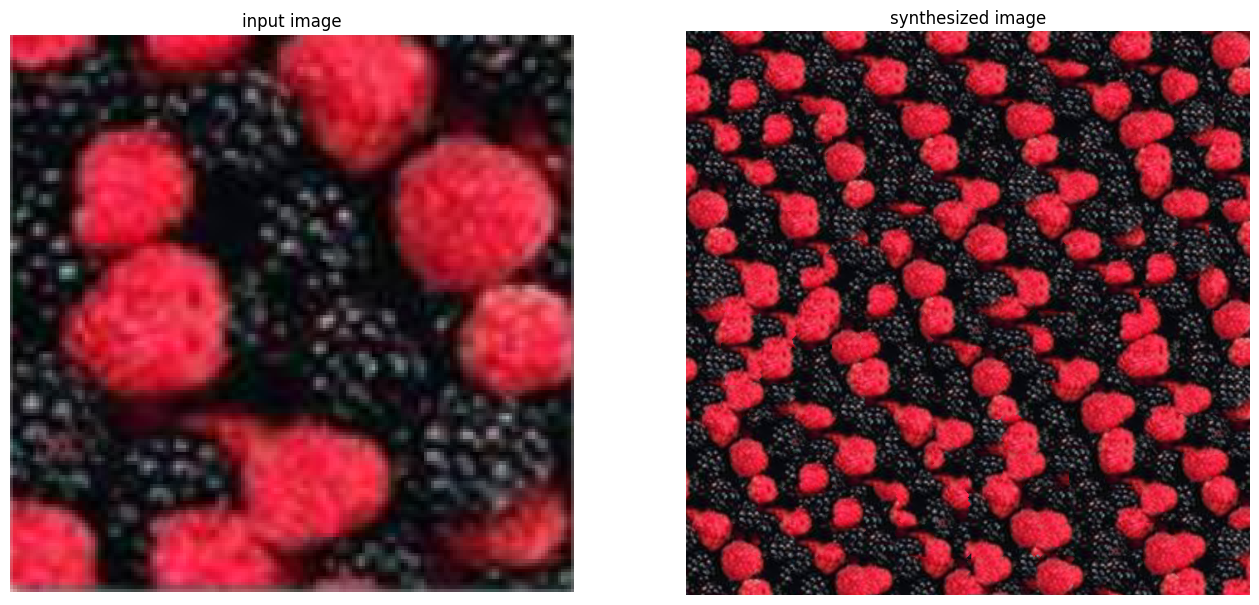

In [ ]:
input_image = cv2.imread('4.png')
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
input_image = util.img_as_float(input_image)

patch_size = 50
num_patches = (16, 16)
quilt_image = create_quilt(input_image, patch_size, num_patches)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.axis('off')
plt.title("input image")

plt.subplot(1, 2, 2)
plt.imshow(quilt_image)
plt.axis('off')
plt.title("synthesized image")

plt.show()